In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import math

from datetime import datetime

## Data

### Trading Dates

First, just a list of trading dates to backtest

In [272]:
TRADING_DATES_FILE_PATH = 'trading_dates.csv'
def load_trading_dates(): 
  return pd.to_datetime(
    pd.read_csv(TRADING_DATES_FILE_PATH, header=None)[0],
  )

In [273]:
TRADING_DATES = load_trading_dates()
TRADING_DATES

0     2000-01-21
1     2000-02-18
2     2000-03-17
3     2000-04-20
4     2000-05-19
         ...    
229   2019-02-15
230   2019-03-15
231   2019-04-18
232   2019-05-17
233   2019-06-21
Name: 0, Length: 234, dtype: datetime64[ns]

### SPX Index Data



In [276]:
SPX_PRICES_FILE_PATH = 'spx_index_prices.csv'
STOCK_PRICES_DATE_COL = 'Date'
STOCK_PRICES_OPEN_COL = 'Open'
STOCK_PRICES_CLOSE_COL = 'Close'
STOCK_PRICES_AVG_COL = 'Avg'

def load_spx_prices():
  spx_prices = pd.read_csv(SPX_PRICES_FILE_PATH)
  spx_prices[STOCK_PRICES_DATE_COL] = pd.to_datetime(spx_prices[STOCK_PRICES_DATE_COL])
  spx_prices[STOCK_PRICES_AVG_COL] = ((spx_prices[STOCK_PRICES_OPEN_COL] + spx_prices[STOCK_PRICES_CLOSE_COL]) / 2)
  
  return spx_prices

In [277]:
STOCK_PRICES = load_spx_prices()
STOCK_PRICES

,Date,Open,High,Low,Close,Adj Close,Volume,Avg
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1462.234985
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1427.320007
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1400.765015
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.779968
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1422.459961
...,...,...,...,...,...,...,...,...
5081,2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7781540000,2447.359985
5082,2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8358500000,2477.424926
5083,2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8755780000,2417.300049
5084,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2401.434936


### SPX Options Data

Now, a whole 600MBs of options data

In [278]:
SPX_OPTION_PRICES_FILE_PATH = 'spx_option_prices.csv'
OPTION_PRICES_DATE_COL = 'date'
OPTION_PRICES_EXPIRATION_COL = 'exdate'
OPTION_PRICES_MATURITY_COL = 'maturity'
OPTION_PRICES_STRIKE_COL = 'strike_price'
OPTION_PRICES_BID_COL = 'best_bid'
OPTION_PRICES_OFFER_COL = 'best_offer'
OPTION_PRICES_SPREAD_COL = 'spread'
OPTION_PRICES_AVG_COL = 'avg'
OPTION_PRICES_DATE_FMT = '%Y%m%d'

def load_option_prices():
  option_prices = pd.read_csv(SPX_OPTION_PRICES_FILE_PATH);
  option_prices[OPTION_PRICES_DATE_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_DATE_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_EXPIRATION_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_EXPIRATION_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_STRIKE_COL] = option_prices[OPTION_PRICES_STRIKE_COL].div(1000)
  option_prices[OPTION_PRICES_MATURITY_COL] = (
    option_prices[OPTION_PRICES_EXPIRATION_COL] - 
    option_prices[OPTION_PRICES_DATE_COL]
  ).dt.days
  option_prices[OPTION_PRICES_SPREAD_COL] = (
    option_prices[OPTION_PRICES_OFFER_COL] - 
    option_prices[OPTION_PRICES_BID_COL]
  )
  option_prices[OPTION_PRICES_AVG_COL] = (
    (
      option_prices[OPTION_PRICES_OFFER_COL] +
      option_prices[OPTION_PRICES_BID_COL]
    ) / 2
  )

  return option_prices

In [279]:
OPTION_PRICES = load_option_prices()
OPTION_PRICES

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
0,108105,2000-01-03,2000-03-18,19991229.0,P,1410.0,36.750,38.750,0,1,...,235.99500,-119.41110,10120210,1470.521157,1,CBOE S&P 500 INDEX,E,75,2.0,37.750
1,108105,2000-01-03,2000-01-22,19991223.0,P,1505.0,55.250,57.250,0,50,...,100.89450,-172.62950,10000760,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,56.250
2,108105,2000-01-03,2000-06-17,20000103.0,P,1350.0,40.750,42.750,290,14570,...,311.57080,-66.86736,10016917,1490.761534,1,CBOE S&P 500 INDEX,E,166,2.0,41.750
3,108105,2000-01-03,2000-01-22,20000103.0,P,1500.0,51.625,53.625,57,505,...,105.71350,-186.79210,10149633,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,52.625
4,108105,2000-01-03,2000-01-22,NaN,P,1540.0,84.875,86.875,0,0,...,68.56206,-96.37443,10056576,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,85.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462523,108105,2019-06-28,2020-06-30,NaN,P,3800.0,824.100,848.000,0,0,...,NaN,NaN,129500433,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,836.050
8462524,108105,2019-06-28,2020-06-30,NaN,P,3900.0,921.200,945.200,0,0,...,NaN,NaN,129500434,2942.162769,1,CBOE S&P 500 INDEX,E,368,24.0,933.200
8462525,108105,2019-06-28,2020-06-30,NaN,P,4000.0,1018.700,1042.500,0,0,...,NaN,NaN,129500435,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.8,1030.600
8462526,108105,2019-06-28,2020-06-30,NaN,P,4100.0,1116.100,1140.000,0,0,...,NaN,NaN,129500436,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,1128.050


## Data Model

Now that we have some data. Let's create data structures for our trading.

## Portfolio


Next, let's create a dataframe to keep track of our portfolio every trading day. We can use this to measure our performance down the road. 

In [283]:
PORTFOLIO_DATE = 'date'
PORTFOLIO_CASH = 'cash'
PORTFOLIO_STOCK_QUANTITY = 'stock_quantity'
PORTFOLIO_OPTION_QUANTITY = 'option_quantity'
PORTFOLIO_OPTION_STRIKE = 'option_strike'
PORTFOLIO_OPTION_EXPIRATION = 'option_expiration_date'

def build_portfolio_log(): 
  portfolio_log = pd.DataFrame(
    columns=[
        PORTFOLIO_DATE,
        PORTFOLIO_CASH,
        PORTFOLIO_STOCK_QUANTITY,
        PORTFOLIO_OPTION_QUANTITY,
        PORTFOLIO_OPTION_STRIKE,
        PORTFOLIO_OPTION_EXPIRATION
    ]
  )
  portfolio_log.index = portfolio_log[PORTFOLIO_DATE]

  return portfolio_log


In [284]:
ex_portfolio_log = build_portfolio_log()
ex_portfolio_log

,date,cash,stock_quantity,option_quantity,option_strike,option_expiration_date
date,,,,,,


After that, let's create a helper function to create a row

In [293]:
def build_portfolio_row(
  date, 
  cash, 
  stock_quantity, 
  option_quantity,
  option_strike,
  option_expiration):
  return pd.Series({
    PORTFOLIO_DATE: date,
    PORTFOLIO_CASH: cash,
    PORTFOLIO_STOCK_QUANTITY: stock_quantity,
    PORTFOLIO_OPTION_QUANTITY: option_quantity,
    PORTFOLIO_OPTION_STRIKE: option_strike,
    PORTFOLIO_OPTION_EXPIRATION: option_expiration,
  })

In [308]:
ex_portfolio_row = build_portfolio_row(
  date=datetime(2000, 1, 3),
  cash=1000,
  stock_quantity=100,
  option_quantity=1000,
  option_strike=1100,
  option_expiration=datetime(2000, 2, 19))

ex_portfolio_row

date                      2000-01-03 00:00:00
cash                                     1000
stock_quantity                            100
option_quantity                          1000
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object

## Goal

Next, let's create a goal data structure. This can encode our preferences for how we want to allocate stock, and what kind of options we want to buy: at what otm range and at what expiration.


In [309]:
GOAL_STOCK_ALLOC = 'stock_alloc'
GOAL_OTM_RANGE = 'otm_range'
GOAL_MATURITY_RANGE = 'maturity_range'

def build_goal(stock_alloc, otm_range, maturity_range):
  return {
    GOAL_STOCK_ALLOC: stock_alloc, 
    GOAL_OTM_RANGE: otm_range, 
    GOAL_MATURITY_RANGE: maturity_range
  }

So if we wanted to allocated 99.5% SPY, and buy options that are within 2-3 month expiration, and 0.3 - 0.5% OTM, we would write

In [310]:
build_goal(stock_alloc=0.995, otm_range=(0.3, 0.5), maturity_range=(60, 90))

{'stock_alloc': 0.995, 'otm_range': (0.3, 0.5), 'maturity_range': (60, 90)}

## Liquidation

In order for us to figure out how much money we have available, let's create some functions to help us liquidate

### SPX

The simplest thing is SPX. given a portfolio, let's liquidate our quantity for the average price at that date

In [351]:
def get_spx_value(date, col):
  spx_price_series = SPX_PRICES[SPX_PRICES[SPX_PRICES_DATE_COL] == date]
  if (spx_price_series.shape[0] != 1):
    raise SystemExit("Uh oh, expected to find one spx price")

  return spx_price_series.iloc[0][col]

def get_stock_price(date):
  return get_spx_value(date, SPX_PRICES_AVG_COL)
  
def liquidate_stock(portfolio_row):
  stock_quantity = portfolio_row[PORTFOLIO_STOCK_QUANTITY] or 0
  stock_price = get_stock_price(portfolio_row[PORTFOLIO_DATE])

  return stock_quantity * stock_price

In [352]:
liquidate_stock(ex_portfolio_row)

146223.49855

### Option

For an option order, we search through the database, to find the option that has the same date, expiration, and strike price

In [353]:
def get_option_sell_price(option_row):
  return option_row[OPTION_PRICES_BID_COL]

def liquidate_option(portfolio_row):
  option_quantity = portfolio_row[PORTFOLIO_OPTION_QUANTITY]
  if not option_quantity or option_quantity == 0:
    return 0

  options_for_this_date = OPTION_PRICES[
      OPTION_PRICES[OPTION_PRICES_DATE_COL] == portfolio_row[PORTFOLIO_DATE]
  ]
  options_with_expiration = options_for_this_date[
    OPTION_PRICES[OPTION_PRICES_EXPIRATION_COL] == 
    portfolio_row[PORTFOLIO_OPTION_EXPIRATION]
  ]
  options_with_strike = options_with_expiration[
    OPTION_PRICES[OPTION_PRICES_STRIKE_COL] == 
    portfolio_row[PORTFOLIO_OPTION_STRIKE]
  ]
  if options_with_strike.empty:
    raise SystemExit("Uh oh. I need to be able to find the option to sell it date={}, option_order={}".format(date, option_order))
  
  option_row = options_with_strike.iloc[0]
  price = get_option_sell_price(option_row)
  
  return option_quantity * price

In [354]:
liquidate_option(ex_portfolio_row)

1187.5

### Putting it together

Now that we have our functions for SPX and options, let's liquidate the portfolio

In [355]:
def liquidate(portfolio_row):
  cash = portfolio_row[PORTFOLIO_CASH]
  return (
    (cash or 0) + 
    liquidate_stock(portfolio_row) + 
    liquidate_option(portfolio_row)
  )

In [356]:
liquidate(ex_portfolio_row)

148410.99855

## Buying an order

Now let's create the logic that will help us buy our SPX and option orders.

### SPX

We want to buy a certain allocation of SPX, and return the cash that's left over

In [357]:
def buy_stock_order(date, cash_available):
  price_of_stock = get_stock_price(date)
  quantity = cash_available // price_of_stock
  cash_remaining = cash_available - (price_of_stock * quantity)
  
  return (quantity, cash_remaining)

In [358]:
buy_spx_order(datetime(2000, 1, 3), 100000)

(68.0, 568.0209860000032)

### Option

Okay, now let's create a function to buy an option. We want this option to be within our "out of the money range", and within our "expiration range". If it's in that range, let's get the cheapest one

First, let's create a helper method to buy an option within the "out of the money range":

In [359]:
def options_for_otm_range(date, options, otm_range):
  current_stock_price = get_stock_price(date)
  min_strike = (1 - otm_range[1]) * current_stock_price
  max_strike = (1 - otm_range[0]) * current_stock_price
  
  return options[
    options[OPTION_PRICES_STRIKE_COL].between(min_strike, max_strike)
  ]

Next, let's put the code together to find the best option orders:

In [360]:
def find_best_option_rows(
  date, 
  otm_range, 
  maturity_range):
  options_on_this_date = OPTION_PRICES[OPTION_PRICES[OPTION_PRICES_DATE_COL] == date]
  options_within_expiration_range = options_on_this_date[
    options_on_this_date[OPTION_PRICES_MATURITY_COL]
      .between(maturity_range[0], maturity_range[1])
  ]
  options_within_otm_range = options_for_otm_range(
    date,
    options_within_expiration_range,
    otm_range
  )
  options_sorted_by_lowest_price_at_highest_strike = options_within_otm_range.sort_values(
    by=[OPTION_PRICES_OFFER_COL, OPTION_PRICES_STRIKE_COL], 
    ascending=[True, False]
  )
  
  return options_sorted_by_lowest_price_at_highest_strike

Let's see how that looks

In [361]:
date = datetime(2000, 1, 3)
spx_price = get_spx_value(date, SPX_PRICES_AVG_COL)
print('date:', date, 'spx price:', spx_price, '30% otm:', spx_price * 0.7, '20% otm:', spx_price * 0.8)
find_best_option_rows(
    date,
    (0.2, 0.3),
    (60, 100)
).sort_values(by=[OPTION_PRICES_EXPIRATION_COL])

date: 2000-01-03 00:00:00 spx price: 1462.2349855 30% otm: 1023.56448985 20% otm: 1169.7879884000001


,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
68,108105,2000-01-03,2000-03-18,20000103.0,P,1025.0,1.625,2.125,17,15695,...,29.38828,-28.18698,10697611,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.50,1.875
93,108105,2000-01-03,2000-03-18,20000103.0,P,1050.0,2.250,2.500,500,9765,...,35.66812,-33.38159,10816465,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.25,2.375
64,108105,2000-01-03,2000-03-18,19991221.0,P,1075.0,2.500,3.250,0,238,...,41.97782,-38.03137,10805755,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,2.875
9,108105,2000-01-03,2000-03-18,20000103.0,P,1100.0,3.125,3.875,10,6745,...,49.43353,-43.36735,10038124,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,3.500
182,108105,2000-01-03,2000-03-18,19991231.0,P,1125.0,3.875,4.625,0,3036,...,57.95005,-49.16476,11709606,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,4.250
132,108105,2000-01-03,2000-03-18,19991231.0,P,1150.0,4.750,5.500,0,12629,...,67.45924,-55.21112,11347246,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,5.125


Now, let's put it together and buy the option:

In [362]:
def find_best_option_row(date, otm_range, maturity_range):
  best_option_rows = find_best_option_rows(date, otm_range, maturity_range)
  if best_option_rows.empty:
    raise SystemExit("wasn't able to find an option for {}".format(date))
  return best_option_rows.iloc[0]

def get_option_buy_price(option_row):
  return option_row[OPTION_PRICES_OFFER_COL]

def buy_option_order(
  cash_available, 
  option_row):
  strike = option_row[OPTION_PRICES_STRIKE_COL]
  expiration = option_row[OPTION_PRICES_EXPIRATION_COL]
  price = get_option_buy_price(option_row)
  quantity = cash_available // price
  
  option_order = build_option_order(quantity=quantity, strike=strike, expiration_date=expiration)
  cash_remaining = cash_available - (quantity * price)
  
  return (option_order, cash_remaining)

In [363]:
date = datetime(2000, 1, 3)
buy_option_order(
    1000,
    find_best_option_row(date, (0.2, 0.3), (40, 100))
)

({'quantity': 592.0,
  'strike': 1100.0,
  'exdate': Timestamp('2000-02-19 00:00:00')},
 1.0)

## Trading

To put it all together, let's write out trading algorithm. Effectively: 

Every trading day, 
- 1) We will first sell everything that we have over our allocation 
- 2) Then we'll take what we have left, and buy at our allocation
- 3) Finally, we'll merge the portfolios 

First, let's create a function, that given our portfolio, will give us the amount that we are "off" from the target

In [349]:
DELTA_STOCK = 'stock'
DELTA_OPTION = 'option'

def compute_deltas(portfolio_row, goal):
  total = liquidate(portfolio_row)
  current_stock = liquidate_stock(portfolio_row)
  goal_stock = total * goal[GOAL_STOCK_ALLOC]

  current_option = liquidate_option(portfolio_row)
  goal_option = total - goal_stock

  return {
    DELTA_STOCK: current_stock - goal_stock,
    DELTA_OPTION: current_option - goal_option
  }

In [350]:
compute_deltas(
  ex_portfolio_row, 
  build_goal(stock_alloc=0.99, otm_range=(0.2, 0.3), maturity_range=(60, 220))
)

{'stock': -703.390014500008, 'option': -296.60998549999204}

Now, let's write a function, which will sell all it can over our allocation

In [ ]:
# TODO

def sell_over_allocation(portfolio_row, goal, option_row):
  deltas = compute_deltas(portfolio_row, goal)
  portfolio_row_after_selling_stock = sell_stock(portfolio_row, deltas[DELTA_STOCK])
  portfolio_row_after_selling_option = sell_option(portfolio_row, deltas)
  
  stock_delta = deltas[DELTA_STOCK]
  option_delta = deltas[DELTAS_OPTION]
  
  if deltas[DELTA_STOCK] > 0:
    portfolio_row = 
  
  if is_same_option_contract(portfolio_row)





In [229]:
sell_over_allocation(
    datetime(2000, 1, 3),
    build_portfolio(
        cash=0, 
        spx_order=build_spx_order(quantity=1100), 
        option_order=build_option_order(quantity=1000, strike=1100, expiration_date=datetime(2000,2,19))
    ),
    build_goal(0.99, (0.2, 0.3), (40, 100)),
    find_best_option_row(datetime(2000, 1, 3), (0.2, 0.3), (40, 200))
)

{'spx_order': {'quantity': 1090.0},
 'option_order': {'quantity': 1000,
  'strike': 1100,
  'exdate': datetime.datetime(2000, 2, 19, 0, 0)},
 'cash': 14622.349855}

Next, let's create a function to buy up at our allocation

In [237]:
def buy_at_allocation(date, portfolio, goal, new_option_row):
  cash_available = portfolio[PORTFOLIO_CASH]
  total = liquidate(date, portfolio)
  spx_goal = goal[GOAL_SPX_ALLOC] * total
  option_goal = total - spx_goal

  spx_current = liquidate_spx_order(date, portfolio[PORTFOLIO_SPX_ORDER])
  option_current = liquidate_option_order(date, portfolio[PORTFOLIO_OPTION_ORDER])
  
  spx_amt_to_buy = spx_goal - spx_current
  spx_amt_to_buy = min(spx_amt_to_buy, cash_available)
  spx_order = None
  if spx_amt_to_buy > 0:
    (spx_order, cash_remaining_after_spx) = buy_spx_order(date, spx_amt_to_buy)
    cash_available = cash_available - spx_amt_to_buy + cash_remaining_after_spx

  option_amt_to_buy = option_goal - option_current
  option_amt_to_buy = min(option_amt_to_buy, cash_available)
  option_order = None
  if option_amt_to_buy > 0:
    (option_order, cash_remaining_after_option) = buy_option_order(
      option_amt_to_buy,
      new_option_row
    )
    cash_available = cash_available - option_amt_to_buy + cash_remaining_after_option

  return build_portfolio(
    spx_order=spx_order, 
    option_order=option_order, 
    cash=cash_available
  )

In [238]:
date = datetime(2000, 1, 3)
buy_at_allocation(
  date,
  build_portfolio(
    cash=10000, 
    spx_order=build_spx_order(quantity=1100), 
    option_order=build_option_order(quantity=1000, strike=1100, expiration_date=datetime(2000,2,19))
  ),
  build_goal(0.995, (0.2, 0.3), (40, 100)), 
  find_best_option_row(date, (0.2, 0.3), (40, 100))
)

{'spx_order': {'quantity': 2.0},
 'option_order': {'quantity': 4095.0,
  'strike': 1100.0,
  'exdate': Timestamp('2000-02-19 00:00:00')},
 'cash': 165.21752899999956}

Finally, let's put it all together and run for one trading date

In [239]:
def trade_for_date(portfolio_row, goal):
  best_option_row = find_best_option_row(date, goal[GOAL_OTM_RANGE], goal[GOAL_MATURITY_RANGE])
  sold_portfolio_row = sell_over_allocation(date, portfolio, goal, best_option_row)
  baught_portfolio_row = sell_over_allocation 
  
  baught_portfolio = buy_at_allocation(date, sold_portfolio, goal, best_option_row)
  sold_portfolio[PORTFOLIO_CASH] = 0
  
  return merge_portfolios(sold_portfolio, baught_portfolio)

## Simulation

Now, let's write code to run the strategy

In [240]:
def simulate(goal, cash):
  trade_book = build_trade_book()
  portfolio = build_portfolio(spx_order=None, option_order=None, cash=cash)
  for date in TRADING_DATES:
    portfolio = trade_for_date(
      date,
      goal,
      portfolio
    )
    set_portfolio_for_date(trade_book, date, portfolio)
  
  return trade_book

Let's write some code to enhance the table, to see how things look

In [241]:
ENHANCED_TRADE_BOOK_TOTAL_VALUE = 'total value'
ENHANCED_TRADE_BOOK_SPX_VALUE = 'spx value'
ENHANCED_TRADE_BOOK_SPX_PERCENT = '% spx'
ENHANCED_TRADE_BOOK_OPTION_VALUE = 'option value'
ENHANCED_TRADE_BOOK_OPTION_PERCENT = '% option'
ENHANCED_TRADE_BOOK_CASH_PERCENT = '% cash'
def enhance_trade_book(trade_book):
  def enhance(row):
    date = row[TRADE_BOOK_DATE]
    portfolio = trade_book_row_to_portfolio(row)
    total = liquidate(date, portfolio)
    spx_value = liquidate_spx_order(date, portfolio[PORTFOLIO_SPX_ORDER])
    option_value = liquidate_option_order(date, portfolio[PORTFOLIO_OPTION_ORDER])
    cash_value = portfolio[PORTFOLIO_CASH]
    return row.append(
      pd.Series({
        ENHANCED_TRADE_BOOK_TOTAL_VALUE: total,
        ENHANCED_TRADE_BOOK_SPX_VALUE: spx_value,
        ENHANCED_TRADE_BOOK_OPTION_VALUE: option_value,
        ENHANCED_TRADE_BOOK_SPX_PERCENT: (spx_value / total) * 100,
        ENHANCED_TRADE_BOOK_OPTION_PERCENT: (option_value / total) * 100,
        ENHANCED_TRADE_BOOK_CASH_PERCENT: (cash_value / total) * 100
      })
    )

  return trade_book.apply(enhance, axis=1)

Let's see how this looks

In [242]:
trade_book = simulate(
  build_goal(spx_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
  100000
)

In [243]:
enhance_trade_book(trade_book)

,date,cash,spx_quantity,option_quantity,option_strike,option_expiration_date,total value,spx value,option value,% spx,% option,% cash
date,,,,,,,,,,,,
2000-01-21,2000-01-21,1344.569846,68.0,727.0,750.0,2000-06-17,99636.500000,98155.617654,136.3125,98.513715,0.136810,1.349475
2000-02-18,2000-02-18,1008.882346,68.0,944.0,700.0,2000-06-17,94094.781530,92967.899184,118.0000,98.802397,0.125405,1.072198
2000-03-17,2000-03-17,565.882346,68.0,1004.0,850.0,2000-06-17,100071.340374,99379.958028,125.5000,99.309111,0.125411,0.565479
2000-04-20,2000-04-20,265.882346,68.0,186.0,900.0,2000-09-16,97992.722686,97308.340340,418.5000,99.301599,0.427073,0.271329
2000-05-19,2000-05-19,1412.212302,67.0,388.0,875.0,2000-09-16,97031.069354,95279.357052,339.5000,98.194689,0.349888,1.455423
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-15,2019-02-15,403.572712,37.0,1722.0,1475.0,2019-04-18,103161.014340,102413.041628,344.4000,99.274946,0.333847,0.391207
2019-03-15,2019-03-15,2697.207722,36.0,2092.0,1450.0,2019-05-17,104409.868064,101398.860342,313.8000,97.116166,0.300546,2.583288
2019-04-18,2019-04-18,2160.957722,36.0,3575.0,1500.0,2019-06-21,106916.829306,104577.121584,178.7500,97.811656,0.167186,2.021158


 And let's write some code to plot how we do.

In [261]:
def simulate_and_compare(goal, cash):
  enhanced_trade_book = enhance_trade_book(simulate(goal, cash))
  (just_spx_order, just_spx_order_cash_remaining) = buy_spx_order(
      TRADING_DATES.iloc[0],
      cash
  )
  def format_for_plot(row):
      date = row[TRADE_BOOK_DATE]
      portfolio = trade_book_row_to_portfolio(row)
      return pd.Series({
          'benchmark_spy': liquidate_spx_order(date, just_spx_order) + just_spx_order_cash_remaining,
          'portfolio_total': row[ENHANCED_TRADE_BOOK_TOTAL_VALUE],
          'portfolio_spy': row[ENHANCED_TRADE_BOOK_SPX_VALUE],
          'portfolio_options': row[ENHANCED_TRADE_BOOK_OPTION_VALUE],
          'portfolio_cash': row[TRADE_BOOK_CASH]
      })
  
  plot_df = enhanced_trade_book.apply(format_for_plot, axis=1)
  plot_df.plot()
  plt.show()

## Exploration

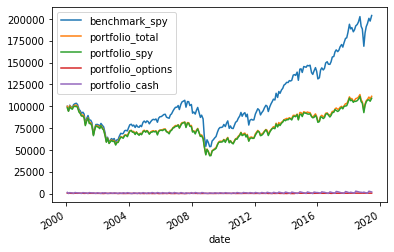

In [262]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    100000
)

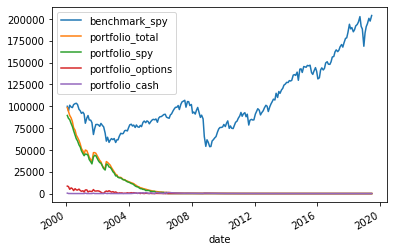

In [269]:
simulate_and_compare(
    build_goal(spx_alloc=0.90, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    100000
)

## Reflection on Above

Hm...something seems off. Looks like the options are barely moving

Some things I have learned
- may be better to operate on df and series directly -- the indirection of "portfolio" is prolly unecc
- can def write the re-alloc algo better
- need to double check the re-alloc algo too -- perhaps it's not buying and selling enough options
- maybe the issue is b/c of the spread on the options

In [270]:
def get_option_buy_price(option_row):
  return option_row[OPTION_PRICES_AVG_COL]
 
def get_option_sell_price(option_row):
  return option_row[OPTION_PRICES_AVG_COL]

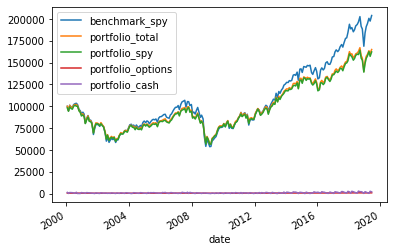

In [265]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    100000
)

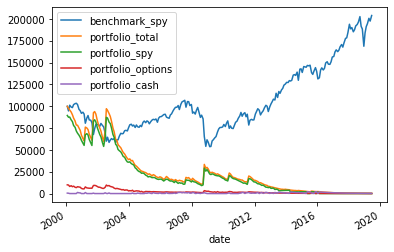

In [266]:
simulate_and_compare(
    build_goal(spx_alloc=0.90, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    100000
)

Above is interesting -- seems like when I set the sell and bid price to be avg, then at least the option prices start to spike

## Q Ratio

In [52]:
Q_RARTIO_FILE_PATH = 'tobins_q.csv'
Q_RATIO_DATE_COL = 'date'
Q_RATIO_VALUE_COL = 'value'

def load_q_ratios():
  q_ratios = pd.read_csv(Q_RARTIO_FILE_PATH)
  q_ratios[Q_RATIO_DATE_COL] = pd.to_datetime(q_ratios[Q_RATIO_DATE_COL])
  q_ratios = q_ratios.set_index(Q_RATIO_DATE_COL, drop=False)
  
  return q_ratios


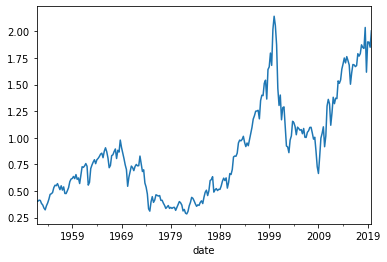

In [53]:
Q_RATIOS = load_q_ratios()
Q_RATIOS[Q_RATIO_VALUE_COL].plot()
plt.show()

In [54]:
def get_q_ratio_for_date(date):
    q_ratios_before_date = Q_RATIOS[Q_RATIOS[Q_RATIO_DATE_COL] < date]
    latest_q_ratio = q_ratios_before_date.last('3D').iloc[0]

    return latest_q_ratio[Q_RATIO_VALUE_COL]

In [55]:
get_q_ratio_for_date(datetime(2000, 1, 3))

2.14224612552741